### Volatility

- <u>__Objective__</u> <br>
To test volatility trading strategies on a portfolio of futures contracts of 4 commodities: crude oil,gasoline, natural gas, heating oil. We test volatility for three time periods: weekly volatility, monthly volatility and the relative volatility.
<br>

- <u>__Method__</u> <br>
We create quintiles of the return volatility for the three time periods (assuming that we're trading everyday) and test 2 strategies:
1. _Strategy 1_: Buy when volatility is low, sell when volatility is high.<br>
We buy futures contracts which are in quintile 1 and and sell contracts which are in quintile 5.
2. _Strategy 2_: Buy when volatility is high, sell when volatility is low.<br>
We buy futures contracts which are in quintile 5 and and sell contracts which are in quintile 1.


- <u>__Results__</u> <br>
Our results indicate that buying contracts when relative volatility is high, and selling when monthly volatility is low returns the best Sharpe ratio of 0.14. Trying the opposite of this strategy i.e buying when volatility is low results in a negative sharpe ratio for all three time periods.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# loading crude, gas, natural gas, heatoil datasets
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
gas = pd.read_csv("Gasoline.txt",sep="\t")
natgas = pd.read_csv("Natural_Gas.txt",sep="\t")
heatoil = pd.read_csv("Heating_Oil.txt",sep="\t")

In [3]:
# daily risk-free rates data (obtained from WRDS)
rf = pd.read_csv("rf.csv",header=0,names=['Date','RF'])
rf.Date = pd.to_datetime(rf.Date)
rf.columns = ['date', 'RF']
rf.set_index('date', inplace = True)

In [4]:
# coverting to datetime columns
commodities = [crude,gas,natgas,heatoil]
for i in commodities:
    i.Date = pd.to_datetime(i.Date,dayfirst=True)

In [5]:
# merging dataframes on the common time period between the 4 commodities
df_merged= reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), commodities)

# showing only first row and last row of dataframe
# dataset ranges from 2005-10-03 --- 2014-02-18
df_merged.iloc[[0, -1]]

,Date,RCLC1,RCLC2,RCLC3,RCLC4,RCLC5,RCLC6,RCLC12,LLCC1,LLCC2,...,HOTC3,HOTC4,HOTC5,HOTC6,HOTC7,HOTC8,HOTC9,HOTC10,HOTC11,HOTC12
0,2005-10-03,65.47,65.29,65.69,65.97,66.16,66.24,65.77,62.80,63.52,...,2.1273,2.1248,2.0898,2.0223,1.9633,1.9223,1.9208,1.9273,1.9408,1.9578
2186,2014-02-18,102.43,102.10,101.21,100.30,99.40,98.45,93.11,110.46,110.11,...,3.0256,3.0163,3.0096,3.0033,2.9980,2.9918,2.9858,2.9793,2.9713,2.9566


In [6]:
# Reshaping data to index by contract and date
cols = list(df_merged.columns)[1:][:-1]
df = pd.melt(df_merged, id_vars=['Date'], value_vars=cols)

# Indicator for not Beginning of Month. 
df['BOM_not'] = (df.Date.shift(1).dt.month == df.Date.dt.month).astype(int)
df.columns = ['date', 'contract', 'price', 'BOM_not']
df.set_index(['contract', 'date'], inplace = True)
df

price  BOM_not
contract date                        
RCLC1    2005-10-03  65.4700        0
         2005-10-04  63.9000        1
         2005-10-05  62.7900        1
         2005-10-06  61.3600        1
         2005-10-07  61.8400        1
...                      ...      ...
HOTC11   2014-02-12   2.9304        1
         2014-02-13   2.9288        1
         2014-02-14   2.9438        1
         2014-02-17   2.9438        1
         2014-02-18   2.9713        1

[109350 rows x 2 columns]

In [7]:
# Calculating Return
df['lag_price'] = df['price'].groupby('contract').shift()
df['RET'] = (df['price']/df['lag_price'] - 1)*df['BOM_not']
df.drop(columns = ['price', 'lag_price', 'BOM_not'], inplace = True)
df

RET
contract date                
RCLC1    2005-10-03       NaN
         2005-10-04 -0.023980
         2005-10-05 -0.017371
         2005-10-06 -0.022774
         2005-10-07  0.007823
...                       ...
HOTC11   2014-02-12 -0.000512
         2014-02-13 -0.000546
         2014-02-14  0.005122
         2014-02-17  0.000000
         2014-02-18  0.009342

[109350 rows x 1 columns]

In [8]:
df['XRET'] = df['RET'] -rf['RF']
df.fillna(value = 0, inplace = True)

In [9]:
# calculating standard deviation of weekly XRETurn
df['STD_WEEKLY'] = df.rolling(5)['XRET'].std()

# calculating standard deviation of monthly XRETurn
df['STD_MONTHLY'] = df.rolling(21)['XRET'].std()

# relative standard deviation
df['STD_RELATIVE'] = df['STD_WEEKLY']/df['STD_MONTHLY']

# weekly volatility of XRETurns
df['WEEKLY_XRET_VOL'] = df['STD_WEEKLY'].groupby('contract').shift()

# monthly volatility of XRETurns
df['MONTHLY_XRET_VOL'] = df['STD_MONTHLY'].groupby('contract').shift()

# lagging the relative volatility
df['RELATIVE_VOL_LAG'] = df['STD_RELATIVE'].groupby('contract').shift()

In [10]:
#create dataframe to store contracts
rev = pd.DataFrame(data=cols,columns=["contract"])

In [11]:
# defining quintiles
numbins = 5
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [12]:
periods = ['WEEKLY_XRET_VOL','MONTHLY_XRET_VOL','RELATIVE_VOL_LAG']

In [13]:
df.dropna(inplace = True)

In [14]:
# Making quintiles
ports = {}
stats = {}
for i in periods:
    df['QUANTILE_' + str(i)] = df[i].groupby('date').apply(quintiles)
    # Calculating Portfolios
    ports[i] = df.groupby(['QUANTILE_' + str(i),'date'])['XRET'].mean()
    # Calculating Stats for each quantile
    stats[i] = ports[i].groupby(['QUANTILE_'  + str(i)]).describe()
    stats[i]['sharpe'] = stats[i]['mean'] / stats[i]['std'] * np.sqrt(12)

In [15]:
stats[periods[0]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_WEEKLY_XRET_VOL,,,,,,,,,
1,2186.0,-0.000067,0.015061,-0.076998,-0.007820,0.000000e+00,0.007932,0.071068,-0.015520
2,2186.0,0.000248,0.015533,-0.080290,-0.007868,0.000000e+00,0.008447,0.092258,0.055379
3,2186.0,0.000296,0.016865,-0.079922,-0.008183,0.000000e+00,0.008907,0.105444,0.060834
4,2186.0,0.000421,0.017386,-0.090776,-0.008437,0.000000e+00,0.009437,0.116919,0.083974
5,2186.0,0.000367,0.021391,-0.093416,-0.011506,-3.475000e-07,0.011269,0.124930,0.059376


In [16]:
stats[periods[1]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_MONTHLY_XRET_VOL,,,,,,,,,
1,2186.0,-0.000111,0.014137,-0.065442,-0.008193,0.0,0.007357,0.080843,-0.027103
2,2186.0,0.000223,0.015575,-0.079253,-0.007858,0.0,0.008910,0.076760,0.049618
3,2186.0,0.000354,0.016838,-0.081390,-0.007697,0.0,0.008729,0.100387,0.072781
4,2186.0,0.000350,0.017411,-0.091716,-0.008278,0.0,0.008973,0.115990,0.069600
5,2186.0,0.000451,0.021733,-0.100571,-0.011657,0.0,0.011247,0.134775,0.071940


In [17]:
stats[periods[2]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_RELATIVE_VOL_LAG,,,,,,,,,
1,2186.0,0.000083,0.017102,-0.092087,-0.008869,0.000000e+00,0.009311,0.088817,0.016856
2,2186.0,0.000398,0.016586,-0.093957,-0.008089,0.000000e+00,0.008598,0.094351,0.083047
3,2186.0,0.000308,0.017078,-0.081854,-0.008213,0.000000e+00,0.008774,0.106104,0.062453
4,2186.0,0.000338,0.016952,-0.083864,-0.008362,0.000000e+00,0.009273,0.114201,0.068987
5,2186.0,0.000139,0.018764,-0.086659,-0.010007,-6.950000e-08,0.009771,0.094079,0.025621


### Trading Rule
Buy when volatility is low, sell when volatility is high

In [28]:
# Summarizing Each Strategy
lowminushigh = {}
for i in periods:
    lowminushigh[i] = ports[i].loc[1] - ports[i].loc[5]
    print(str(i))
    print(lowminushigh[i].describe(), '\n')

WEEKLY_XRET_VOL
count    2186.000000
mean       -0.000434
std         0.019486
min        -0.150656
25%        -0.009549
50%         0.000000
75%         0.009063
max         0.076368
Name: XRET, dtype: float64 

MONTHLY_XRET_VOL
count    2186.000000
mean       -0.000562
std         0.019104
min        -0.160501
25%        -0.009126
50%         0.000000
75%         0.008377
max         0.076540
Name: XRET, dtype: float64 

RELATIVE_VOL_LAG
count    2186.000000
mean       -0.000056
std         0.018267
min        -0.119805
25%        -0.008304
50%         0.000000
75%         0.008668
max         0.071440
Name: XRET, dtype: float64 



WEEKLY_XRET_VOL day volatility based strategy
t-stat:  -1.041684437505675
Sharpe Ratio: -0.07717945725506112
MONTHLY_XRET_VOL day volatility based strategy
t-stat:  -1.3753002818002396
Sharpe Ratio: -0.10189739376949924


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


RELATIVE_VOL_LAG day volatility based strategy
t-stat:  -0.1422220778043961
Sharpe Ratio: -0.010537378095917425


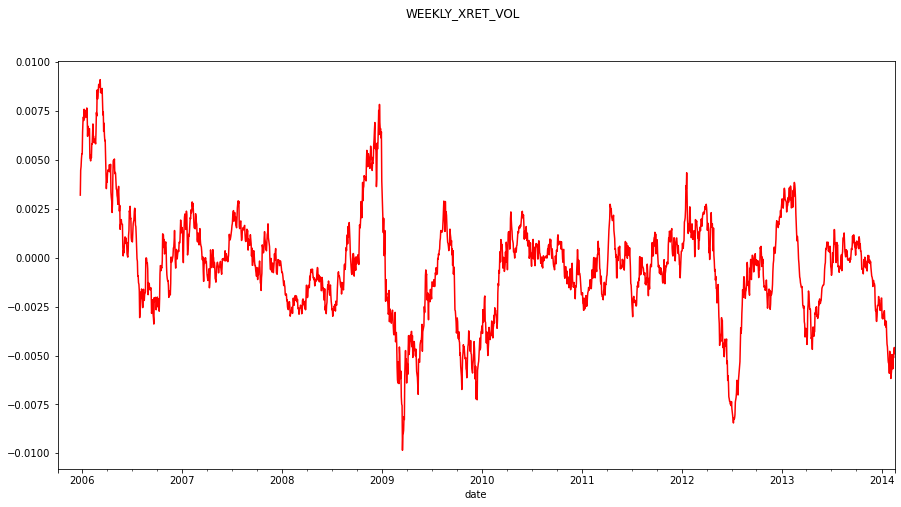

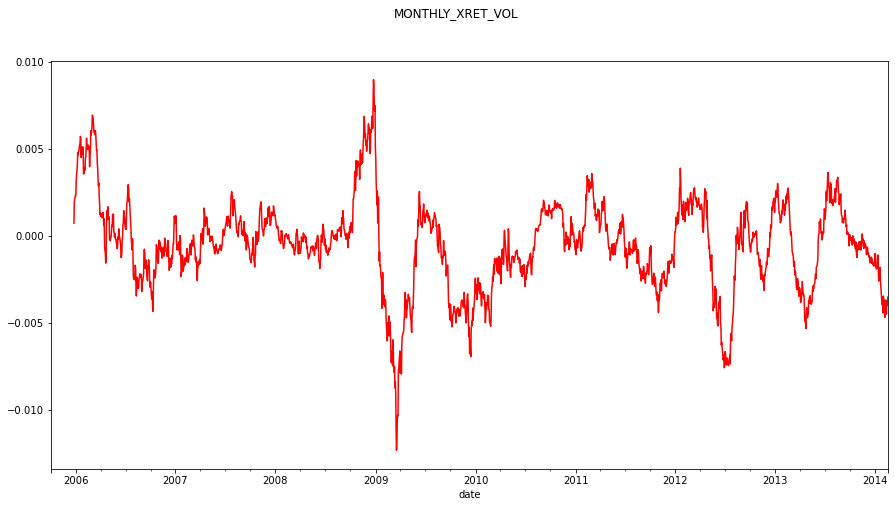

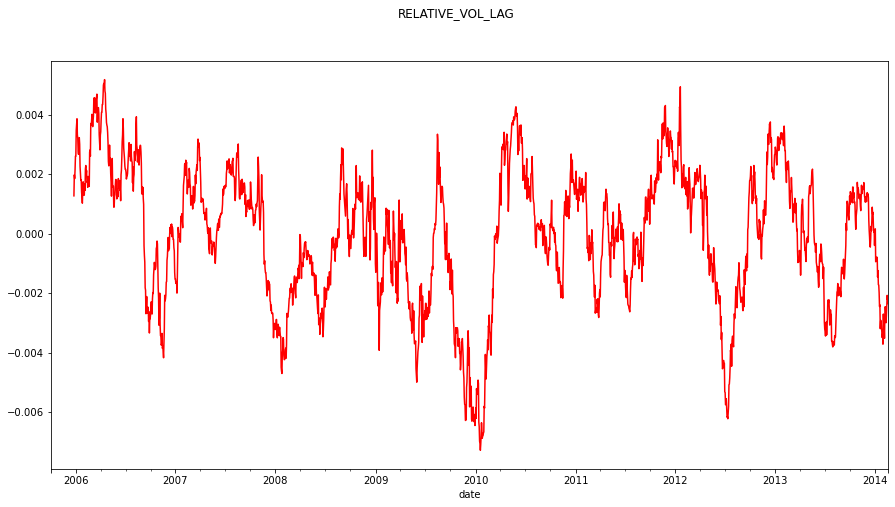

In [29]:
# Calculating figures and plotting portfolio
for i in periods:
    print(str(i) + ' day volatility based strategy')
    # Calculating T Stat and Sharpe Ratio
    tstat = lowminushigh[i].describe()['mean']/(lowminushigh[i].describe()['std'] / np.sqrt(lowminushigh[i].describe()['count']))
    print('t-stat: ', tstat)
    sharpe = lowminushigh[i].describe()['mean']/lowminushigh[i].describe()['std'] * np.sqrt(12)
    print('Sharpe Ratio:', sharpe)
    # Plotting Portfolio Performance
    fig = plt.figure(figsize = (15, 7.5))
    lowminushigh[i].rolling(60).mean().plot(color='r')
    fig.suptitle(str(i))
    fig.show()
    fig.savefig('volatility_' + str(i) + '.png')

### Trading Rule
Buy when volatility is high, sell when volatility is low

In [30]:
# Summarizing Each Strategy
highminuslow = {}
for i in periods:
    highminuslow[i] = ports[i].loc[numbins] - ports[i].loc[1]
    print(str(i))
    print(highminuslow[i].describe(), '\n')

WEEKLY_XRET_VOL
count    2186.000000
mean        0.000434
std         0.019486
min        -0.076368
25%        -0.009063
50%         0.000000
75%         0.009549
max         0.150656
Name: XRET, dtype: float64 

MONTHLY_XRET_VOL
count    2186.000000
mean        0.000562
std         0.019104
min        -0.076540
25%        -0.008377
50%         0.000000
75%         0.009126
max         0.160501
Name: XRET, dtype: float64 

RELATIVE_VOL_LAG
count    2186.000000
mean        0.000056
std         0.018267
min        -0.071440
25%        -0.008668
50%         0.000000
75%         0.008304
max         0.119805
Name: XRET, dtype: float64 



WEEKLY_XRET_VOL day volatility based strategy
t-stat:  1.041684437505675
Sharpe Ratio: 0.07717945725506112
MONTHLY_XRET_VOL day volatility based strategy
t-stat:  1.3753002818002396
Sharpe Ratio: 0.10189739376949924


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


RELATIVE_VOL_LAG day volatility based strategy
t-stat:  0.1422220778043961
Sharpe Ratio: 0.010537378095917425


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


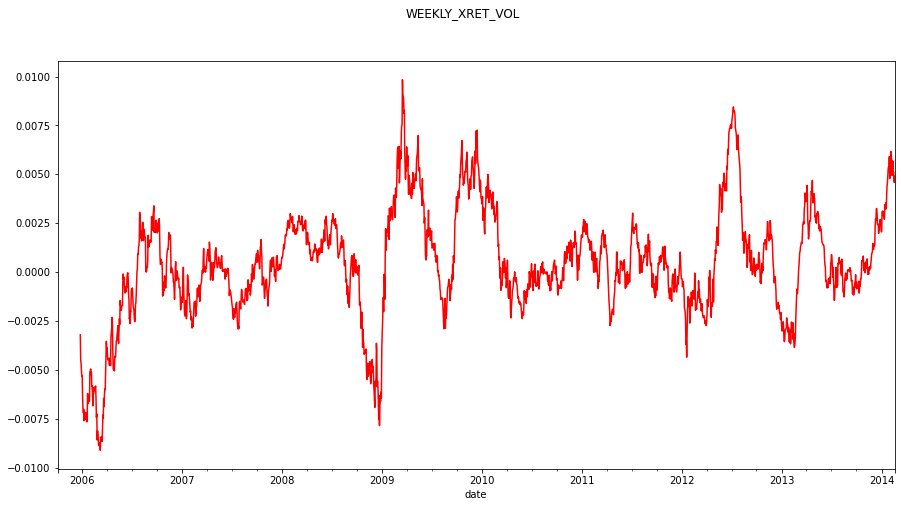

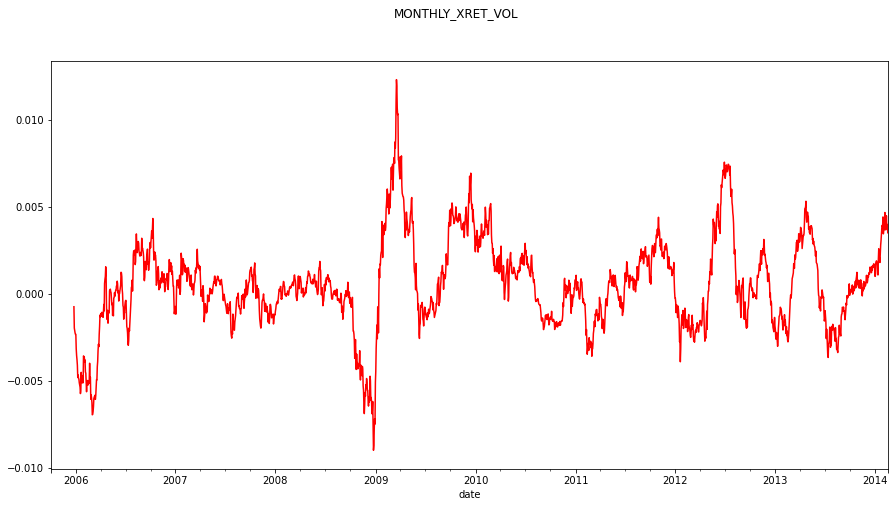

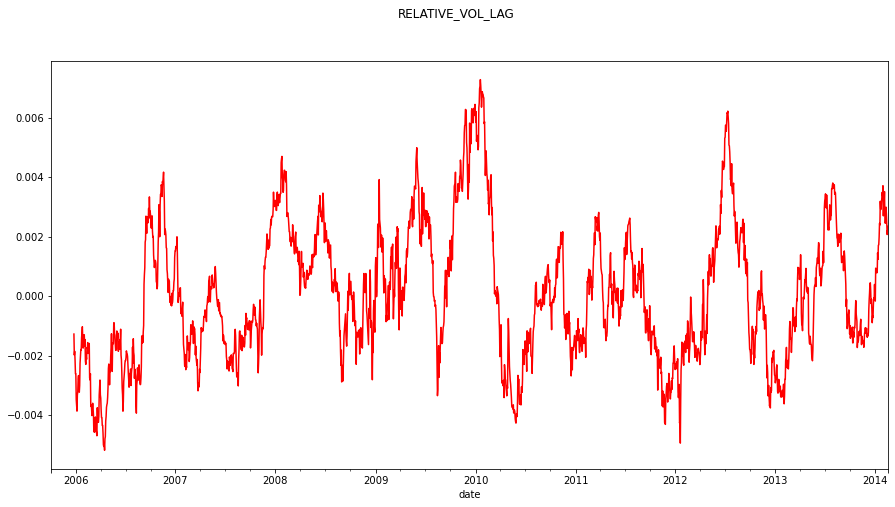

In [31]:
# Calculating figures and plotting portfolio
for i in periods:
    print(str(i) + ' day volatility based strategy')
    # Calculating T Stat and Sharpe Ratio
    tstat = highminuslow[i].describe()['mean']/(highminuslow[i].describe()['std'] / np.sqrt(highminuslow[i].describe()['count']))
    print('t-stat: ', tstat)
    sharpe = highminuslow[i].describe()['mean']/highminuslow[i].describe()['std'] * np.sqrt(12)
    print('Sharpe Ratio:', sharpe)
    # Plotting Portfolio Performance
    fig = plt.figure(figsize = (15, 7.5))
    highminuslow[i].rolling(60).mean().plot(color='r')
    fig.suptitle(str(i))
    fig.show()
    fig.savefig('volatility_' + str(i) + '.png')

In [22]:
# df2 = df.reorder_levels(['date','contract'])
# df2.sort_index(inplace=True)
# df2.dropna(inplace=True)
# df2

In [23]:
# # creating quintiles for the return volatility of each of these trading periods
# periods = ['WEEKLY_RET_VOL','MONTHLY_RET_VOL','RELATIVE_VOL_LAG']

# for i in periods: 
#     df2['QUINTILE_' + i] = df2[i].groupby('date').apply(quintiles)

In [24]:
# # function for portfolio: buy when vol is low, sell when vol is high
# def portfolio_lowvol(rank, data):
#     temp_port = data.groupby([rank,'date'])['RET'].mean()
#     temp_port.dropna(inplace=True)
#     lowminushigh= temp_port.loc[1] - temp_port.loc[5]
    
#     tstat = lowminushigh.describe()['mean']/(lowminushigh.describe()['std'] / np.sqrt(lowminushigh.describe()['count']))
#     sharpe = lowminushigh.describe()['mean']/lowminushigh.describe()['std'] * np.sqrt(250)
    
#     print(f'tstat for portfolio based on {rank}:{tstat}')
#     print(f'sharpe ratio for portfolio based on {rank}:{sharpe}')
    
#     return lowminushigh.describe()

In [25]:
# # return results
# quintile_cols = df2.loc[:,df2.columns.str.startswith('QUINTILE')].columns.to_list()

# for i in quintile_cols:
#     print(portfolio_lowvol(i, data = df2), '\n')

In [26]:
# # function for portfolio: buy when vol is high, sell when vol is low
# def portfolio_highvol(rank, data):
#     temp_port = data.groupby([rank,'date'])['RET'].mean()
#     temp_port.dropna(inplace=True)
#     highminuslow= temp_port.loc[5] - temp_port.loc[1]
    
#     tstat = highminuslow.describe()['mean']/(highminuslow.describe()['std'] / np.sqrt(highminuslow.describe()['count']))
#     sharpe = highminuslow.describe()['mean']/highminuslow.describe()['std'] * np.sqrt(250)
    
#     print(f'tstat for portfolio based on {rank}:{tstat}')
#     print(f'sharpe ratio for portfolio based on {rank}:{sharpe}')
    
#     return highminuslow.describe()

In [27]:
# # return results
# for i in quintile_cols:
#     print(portfolio_highvol(i, data = df2), '\n')